# Revision on pyspark Part1 Through KNN recommender system use case

In [2]:
%config IPCompleter.greedy=True

# Apache Spark's philosophy
Apache spark is a unified computing engine and set of librariries for big data for parallel data processing on computers

# RDD vs. Dataframe
* **Spark RDD APIs:** An RDD stands for Resilient Distributed Datasets. It is Read-only partition collection of records. RDD is the fundamental data structure of Spark. It allows a programmer to perform in-memory computations on large clusters in a fault-tolerant manner.


* **Dataframe :** Unlike an RDD, data organized into named columns. For example a table in a relational database. It is an immutable distributed collection of data. DataFrame in Spark allows developers to impose a structure onto a distributed collection of data, allowing higher-level abstraction.

RDD offers low-level functionality and control. The DataFrame and Dataset allow custom view and structure. It offers high-level domain-specific operations, saves space, and executes at high speed(No inbuilt optimization engine is available in RDD but there is in Dataframe.). Select one out of DataFrames and/or Dataset or RDDs APIs, that meets your needs and play with Spark.

# Spark Session
As we know, in previous versions, spark context is the entry point for spark, As RDD was the main API, it was created and manipulated using context API’s. For every other API, we needed to use a different context.

For streaming we needed streamingContext. For SQL sqlContext and for hive hiveContext.But as dataSet and DataFrame API’s are becoming new standalone API’s we need an entry-point build for them. So in spark 2.0, we have a new entry point build for DataSet and DataFrame API’s called as Spark-Session.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import  col, column, expr, isnull,instr
from pyspark.sql.types import DoubleType
from pyspark.sql.types import StringType
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.functions import corr


In [7]:
#Note that we do not use the spark context anymore
#our entry line now is "spark" instead of sc
from pyspark.sql import SparkSession

#getOrCreate()
#Gets an existing SparkSession or, if there is no existing one, creates a new one based on the options set in this builder.
#This method first checks whether there is a valid global default SparkSession, and if yes, return that one.
#If no valid global default SparkSession exists, the method creates a new SparkSession and assigns the newly created 
#ySparkSession as the global default.


spark = SparkSession.builder.appName("Revision").master("local").getOrCreate()
spark.conf.set("spark.driver.cores","5")
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v2.4.3 
 Master 
 local[8] 
 AppName 
 Databricks Shell

# KNN Recommender System
A Recommender System is one of the most famous applications of data science and machine learning.

Types Of Recommender systems
1. Content Based filtering.
1. Collaborative filtering.

we are going to build a simple recommender system and revise our content through this use case.

# Reading the data 
we are going to use Movielens dataset. You can read more about it from the link 
 https://grouplens.org/datasets/movielens/

In [10]:
#Reading movies table
movie_names = spark.read.csv("/FileStore/tables/movies.csv",header=True,inferSchema=True)
movie_names.show(5)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

In [11]:
#Reading ratings table
#ratings_data = spark.read.csv("../Data/ratings.csv",header=True,inferSchema=True)
ratings_data = spark.read.csv("/FileStore/tables/ratings.csv",header=True,inferSchema=True)

In [12]:
#schema on read
ratings_data.printSchema()

root
-- userId: integer (nullable = true)
-- movieId: integer (nullable = true)
-- rating: double (nullable = true)
-- timestamp: integer (nullable = true)

In [13]:
ratings_data.show(5)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

In [14]:
#without header = true
#if affects the header, first row and the schema
NoHeaderDf = spark.read.csv("/FileStore/tables/ratings.csv",inferSchema=True)
NoHeaderDf.show(5)

+------+-------+------+---------+
 _c0| _c1| _c2| _c3|
+------+-------+------+---------+
userId|movieId|rating|timestamp|
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
+------+-------+------+---------+
only showing top 5 rows

In [15]:
#all of them are read as string
NoHeaderDf.printSchema()

root
-- _c0: string (nullable = true)
-- _c1: string (nullable = true)
-- _c2: string (nullable = true)
-- _c3: string (nullable = true)

In [16]:
#what if the incoming data itself has some unwanted data affects the schema 
#you can pass the schema manually

from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType

TheSchema = StructType([
    StructField("user", IntegerType(), True),
    StructField("item", IntegerType(), True),
    StructField("rate", DoubleType(), True),
    StructField("TimeStamp", IntegerType(), True)])

NoHeaderDfWithSchema = spark.read.csv("/FileStore/tables/ratings.csv",header=False,schema=TheSchema)

In [17]:
NoHeaderDfWithSchema.show(5)

+----+----+----+---------+
user|item|rate|TimeStamp|
+----+----+----+---------+
null|null|null| null|
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
+----+----+----+---------+
only showing top 5 rows

# Drop Transformation

In [19]:
#Dropping
#Dropping nulls
NoHeaderDfWithSchemadna = NoHeaderDfWithSchema.dropna()

In [20]:
NoHeaderDfWithSchema.where(col("TimeStamp").isNull()).show(2)


+----+----+----+---------+
user|item|rate|TimeStamp|
+----+----+----+---------+
null|null|null| null|
+----+----+----+---------+

In [21]:
NoHeaderDfWithSchema.where(col("TimeStamp").isNotNull()).show(2)

+----+----+----+---------+
user|item|rate|TimeStamp|
+----+----+----+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
+----+----+----+---------+
only showing top 2 rows

In [22]:
#Dropping column
#in our cas we don't need TimeStamp column
ratings_data = ratings_data.drop("TimeStamp")

# Converting pyspark dataframe to Pandas DF

In [24]:
#Convert Spark Dataframe to Pandas DF
#You can convert dataframe to pandas but  note that the use of the .toPandas() method should only 
#be used if the resulting Pandas's DataFrame is expected to be small, as all the data is loaded into the
#driver's memory. If you have a large Spark DataFrame within your cluster,this means that all of this data will 
#be moved from Spark worker nodes to the driver to perform the conversion to Pandas.

ratings_data.limit(5).toPandas()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


# Joinning
what we need now to link the movies ids  in ratings data to the their names in movie names table and put them in one table to recommend with the titles of movies not with ids

In [26]:
#use join
#the command below will raise an error as you have to define the condition of joinning
#ratings_data.join(movie_names).show(5)

#One movieId column
movie_data = ratings_data.join(movie_names,on ="movieId")
movie_data.show(5)

+-------+------+------+--------------------+--------------------+
movieId|userId|rating| title| genres|
+-------+------+------+--------------------+--------------------+
 1| 1| 4.0| Toy Story (1995)|Adventure|Animati...|
 3| 1| 4.0|Grumpier Old Men ...| Comedy|Romance|
 6| 1| 4.0| Heat (1995)|Action|Crime|Thri...|
 47| 1| 5.0|Seven (a.k.a. Se7...| Mystery|Thriller|
 50| 1| 5.0|Usual Suspects, T...|Crime|Mystery|Thr...|
+-------+------+------+--------------------+--------------------+
only showing top 5 rows

In [27]:
 ratings_data.join(movie_names,ratings_data.movieId == movie_names.movieId ).show(5)

+------+-------+------+-------+--------------------+--------------------+
userId|movieId|rating|movieId| title| genres|
+------+-------+------+-------+--------------------+--------------------+
 1| 1| 4.0| 1| Toy Story (1995)|Adventure|Animati...|
 1| 3| 4.0| 3|Grumpier Old Men ...| Comedy|Romance|
 1| 6| 4.0| 6| Heat (1995)|Action|Crime|Thri...|
 1| 47| 5.0| 47|Seven (a.k.a. Se7...| Mystery|Thriller|
 1| 50| 5.0| 50|Usual Suspects, T...|Crime|Mystery|Thr...|
+------+-------+------+-------+--------------------+--------------------+
only showing top 5 rows

In [28]:
ratings_data.join(movie_names).where(ratings_data.movieId == movie_names.movieId ).show(5)

+------+-------+------+-------+--------------------+--------------------+
userId|movieId|rating|movieId| title| genres|
+------+-------+------+-------+--------------------+--------------------+
 1| 1| 4.0| 1| Toy Story (1995)|Adventure|Animati...|
 1| 3| 4.0| 3|Grumpier Old Men ...| Comedy|Romance|
 1| 6| 4.0| 6| Heat (1995)|Action|Crime|Thri...|
 1| 47| 5.0| 47|Seven (a.k.a. Se7...| Mystery|Thriller|
 1| 50| 5.0| 50|Usual Suspects, T...|Crime|Mystery|Thr...|
+------+-------+------+-------+--------------------+--------------------+
only showing top 5 rows

# Using spark.sql
Register the tables fisrt then write sql queries

In [30]:
movie_names.createOrReplaceTempView("movie_names")
ratings_data.createOrReplaceTempView("ratings_data")

In [31]:
movie_data2 = spark.sql("select * \
                        from ratings_data,movie_names \
                        where movie_names.movieId = ratings_data.movieId")
movie_data2.show(5)

+------+-------+------+-------+--------------------+--------------------+
userId|movieId|rating|movieId| title| genres|
+------+-------+------+-------+--------------------+--------------------+
 1| 1| 4.0| 1| Toy Story (1995)|Adventure|Animati...|
 1| 3| 4.0| 3|Grumpier Old Men ...| Comedy|Romance|
 1| 6| 4.0| 6| Heat (1995)|Action|Crime|Thri...|
 1| 47| 5.0| 47|Seven (a.k.a. Se7...| Mystery|Thriller|
 1| 50| 5.0| 50|Usual Suspects, T...|Crime|Mystery|Thr...|
+------+-------+------+-------+--------------------+--------------------+
only showing top 5 rows

In [32]:
#using expr
from pyspark.sql.functions import  col, column, expr
# Colum transformation referring to a dataframe
t1 = movie_data.movieId
t2 = movie_data['movieId']
t3 = movie_data[1]
t4 = movie_data['rating'] == 5 
# Column tranformation declared independent of a dataframe
t5 = column("rating")
t6 = expr("rating")
t7 = column("rating")*2
# All above produce Columns not dataframes !!!!!!!!
# All above could be applied on ANY dataframe
# You need another function to apply them to a dataframe 
#All the return type is column type
for trans in [t1, t2, t3, t4, t5, t6, t7]:
    print(trans)

Column<b'movieId'>
Column<b'movieId'>
Column<b'userId'>
Column<b'(rating = 5)'>
Column<b'rating'>
Column<b'rating'>
Column<b'(rating * 2)'>

In [33]:
movie_data.selectExpr("title", "(rating = 5)")\
  .show(3)

+--------------------+------------+
 title|(rating = 5)|
+--------------------+------------+
 Toy Story (1995)| false|
Grumpier Old Men ...| false|
 Heat (1995)| false|
+--------------------+------------+
only showing top 3 rows

In [34]:
movie_data.select("title",expr("(rating = 5)")).show(3)

+--------------------+------------+
 title|(rating = 5)|
+--------------------+------------+
 Toy Story (1995)| false|
Grumpier Old Men ...| false|
 Heat (1995)| false|
+--------------------+------------+
only showing top 3 rows

# Adding Column

In [36]:
movie_data.selectExpr("*", "(rating*2) as DoubleRate").show(3)

+-------+------+------+--------------------+--------------------+----------+
movieId|userId|rating| title| genres|DoubleRate|
+-------+------+------+--------------------+--------------------+----------+
 1| 1| 4.0| Toy Story (1995)|Adventure|Animati...| 8.0|
 3| 1| 4.0|Grumpier Old Men ...| Comedy|Romance| 8.0|
 6| 1| 4.0| Heat (1995)|Action|Crime|Thri...| 8.0|
+-------+------+------+--------------------+--------------------+----------+
only showing top 3 rows

In [37]:
movie_data.withColumn("DoubleRate",t7).show(3)

+-------+------+------+--------------------+--------------------+----------+
movieId|userId|rating| title| genres|DoubleRate|
+-------+------+------+--------------------+--------------------+----------+
 1| 1| 4.0| Toy Story (1995)|Adventure|Animati...| 8.0|
 3| 1| 4.0|Grumpier Old Men ...| Comedy|Romance| 8.0|
 6| 1| 4.0| Heat (1995)|Action|Crime|Thri...| 8.0|
+-------+------+------+--------------------+--------------------+----------+
only showing top 3 rows

In [38]:
movie_data.select("*",expr( "(rating*2) as DoubleRate")).show(3)

+-------+------+------+--------------------+--------------------+----------+
movieId|userId|rating| title| genres|DoubleRate|
+-------+------+------+--------------------+--------------------+----------+
 1| 1| 4.0| Toy Story (1995)|Adventure|Animati...| 8.0|
 3| 1| 4.0|Grumpier Old Men ...| Comedy|Romance| 8.0|
 6| 1| 4.0| Heat (1995)|Action|Crime|Thri...| 8.0|
+-------+------+------+--------------------+--------------------+----------+
only showing top 3 rows

In [39]:
movie_data.select("*", expr( "(rating*2)").alias("DoubleRate")).show(3)

+-------+------+------+--------------------+--------------------+----------+
movieId|userId|rating| title| genres|DoubleRate|
+-------+------+------+--------------------+--------------------+----------+
 1| 1| 4.0| Toy Story (1995)|Adventure|Animati...| 8.0|
 3| 1| 4.0|Grumpier Old Men ...| Comedy|Romance| 8.0|
 6| 1| 4.0| Heat (1995)|Action|Crime|Thri...| 8.0|
+-------+------+------+--------------------+--------------------+----------+
only showing top 3 rows

In [40]:
movie_data.selectExpr("avg(rating)").show()

+-----------------+
 avg(rating)|
+-----------------+
3.501556983616962|
+-----------------+

In [41]:
movie_data.selectExpr("avg(rating)").collect()[0][0]

Out[ 34 ]: 3.501556983616962

In [42]:
#Back to our recommender system we need to get the avg rate for each movie
#first we select the two columns we need from the dataframe
movie_id_title = movie_data.select("movieId","title")
movie_id_title.show(5)

+-------+--------------------+
movieId| title|
+-------+--------------------+
 1| Toy Story (1995)|
 3|Grumpier Old Men ...|
 6| Heat (1995)|
 47|Seven (a.k.a. Se7...|
 50|Usual Suspects, T...|
+-------+--------------------+
only showing top 5 rows

# Get the Average rating for each movie

In [44]:
#the output of groupBy is groupedData and we need to apply aggregation function after grouping
from pyspark.sql.functions import desc

AvgRating = movie_data.groupBy("title").agg({"rating": "avg"})\
.withColumnRenamed("avg(rating)", "rating")
AvgRatingSorted = AvgRating.sort(desc("rating"))
AvgRatingSorted.show(5)

+--------------------+------+
 title|rating|
+--------------------+------+
English Vinglish ...| 5.0|
Reform School Gir...| 5.0|
Martin Lawrence L...| 5.0|
Bill Hicks: Revel...| 5.0|
Zeitgeist: Moving...| 5.0|
+--------------------+------+
only showing top 5 rows

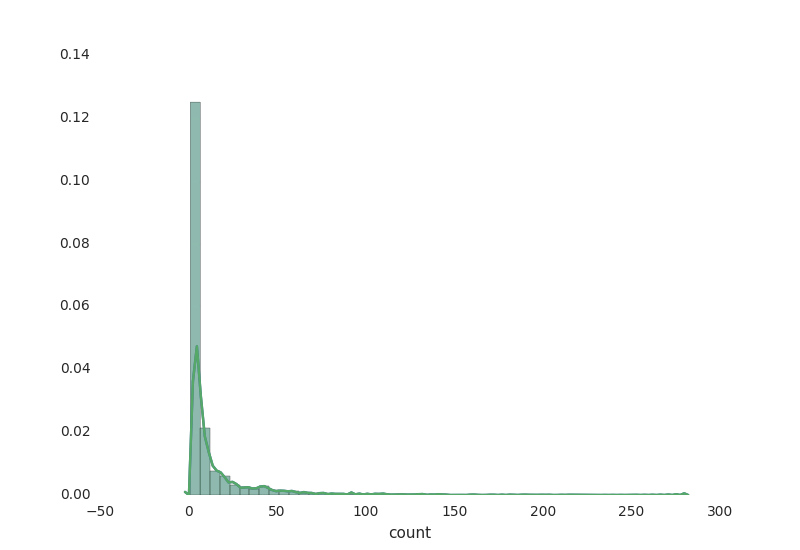

In [45]:
MoviesCount = movie_data.groupBy("title").count()
MoviesCountSample = MoviesCount.sample(withReplacement = False,fraction=0.5, seed=3)
MoviesCountSamplepd = MoviesCountSample.toPandas()
display(sns.distplot(MoviesCountSamplepd['count']).figure)

In [46]:
#The movies have now been sorted according to the ascending
#order of their ratings. However, there is a problem. 
#A movie can make it to the top of the above list even if only a single user has given it five stars. 
#Therefore, the above stats can be misleading. Normally, a movie which is really a good one gets a higher 
#rating by a large number of users.
#for example the movie below

#keep in mind after Transformation we need an action to run it (lazy evaluation)
#this movie was rated by only one user

#where or filter accept Column objects or expressions
movie_data.where("title=='Villain (1971)'").show()

+-------+------+------+--------------+--------------------+
movieId|userId|rating| title| genres|
+-------+------+------+--------------+--------------------+
 136850| 329| 5.0|Villain (1971)|Crime|Drama|Thriller|
+-------+------+------+--------------+--------------------+

In [47]:
movie_data.where(col("title")=='Villain (1971)').show()

+-------+------+------+--------------+--------------------+
movieId|userId|rating| title| genres|
+-------+------+------+--------------+--------------------+
 136850| 329| 5.0|Villain (1971)|Crime|Drama|Thriller|
+-------+------+------+--------------+--------------------+

In [48]:
movie_data.filter("title=='Villain (1971)'").show()

+-------+------+------+--------------+--------------------+
movieId|userId|rating| title| genres|
+-------+------+------+--------------+--------------------+
 136850| 329| 5.0|Villain (1971)|Crime|Drama|Thriller|
+-------+------+------+--------------+--------------------+

In [49]:
movie_data.createOrReplaceTempView("movie_data")
spark.sql("select *\
           from movie_data\
           where title=='Villain (1971)' ").show(3)

+-------+------+------+--------------+--------------------+
movieId|userId|rating| title| genres|
+-------+------+------+--------------+--------------------+
 136850| 329| 5.0|Villain (1971)|Crime|Drama|Thriller|
+-------+------+------+--------------+--------------------+

In [50]:
#Code Here
movie_data.groupBy("title","movieId").agg({"rating":"avg","movieId":"count"}).show(5)

+--------------------+-------+------------------+--------------+
 title|movieId| avg(rating)|count(movieId)|
+--------------------+-------+------------------+--------------+
 Broken Arrow (1996)| 95|3.0238095238095237| 84|
 Sliver (1993)| 540|2.6666666666666665| 18|
 Jack (1996)| 765|3.1578947368421053| 19|
Snakes on a Plane...| 46965| 2.642857142857143| 14|
 Mary and Max (2009)| 71899| 4.2| 10|
+--------------------+-------+------------------+--------------+
only showing top 5 rows

# Finding Similarities between movies

In [52]:
#Making sure the one user rate the movie one time
movie_data.groupBy("userId","movieId").count().where("count>1").show()

+------+-------+-----+
userId|movieId|count|
+------+-------+-----+
+------+-------+-----+

In [53]:
movie_data.show(5)

+-------+------+------+--------------------+--------------------+
movieId|userId|rating| title| genres|
+-------+------+------+--------------------+--------------------+
 1| 1| 4.0| Toy Story (1995)|Adventure|Animati...|
 3| 1| 4.0|Grumpier Old Men ...| Comedy|Romance|
 6| 1| 4.0| Heat (1995)|Action|Crime|Thri...|
 47| 1| 5.0|Seven (a.k.a. Se7...| Mystery|Thriller|
 50| 1| 5.0|Usual Suspects, T...|Crime|Mystery|Thr...|
+-------+------+------+--------------------+--------------------+
only showing top 5 rows

In [54]:
#KNN will calculate the “distance” between the target movie and every other movie in its database, then it ranks its distances and returns the top K nearest neighbor movies as the most similar movie recommendations.

#limiting the data for trial only as pivot is expensive
user_movie_rating = movie_data.limit(300).groupBy("userId").pivot("movieId").sum("rating")
#x.toPandas()
user_movie_rating = user_movie_rating.fillna(0)
user_movie_rating.toPandas()

,userId,1,3,6,31,47,50,70,101,110,...,91529,91658,99114,106782,109487,112552,114060,115713,122882,131724
0,1,4.0,4.0,4.0,0.0,5.0,5.0,3.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,2.5,3.5,5.0,3.0,4.0,2.0,3.5,5.0,5.0
2,3,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
user_movie_rating = movie_data.limit(300).groupBy("userId").pivot("movieId").sum("rating")
user_movie_rating = user_movie_rating.fillna(0)
user_movie_rating.toPandas().head()

,userId,1,2,3,4,5,6,7,8,9,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,471,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
user_movie_rating.stat.corr("1", '31')

Out[ 96 ]: 0.050349159344617964

In [57]:
cSchema = StructType([StructField("movieID", StringType()),StructField("correlation", DoubleType())])

def movieLikes(movieName):
    actual_df = spark.createDataFrame([],schema=cSchema)
    for withMovie in user_movie_rating.columns:
        corr_value = user_movie_rating.stat.corr("%s" %movieName, "%s" %withMovie)
        #print(corr_value)
        newRow = spark.createDataFrame([("%s" %withMovie , corr_value)], actual_df.columns)
        #Concatenating and Appending Rows (Union)
        actual_df = actual_df.union(newRow)
    return actual_df

In [58]:
movieLikesDf = movieLikes("110")

In [59]:
sortedmovieLikesDf = movieLikesDf.sort(desc("correlation")).limit(10)
sortedmovieLikesDf.show()

In [60]:
sortedmovieLikesDf.join(ratings_mean_count, on="movieID").show()

# Working with Strings

In [62]:
movie_names.where(movie_names.title.like("%Die Hard%")).show()

+-------+--------------------+--------------------+----+
movieId| title| genres|Year|
+-------+--------------------+--------------------+----+
 165|Die Hard: With a ...|Action|Crime|Thri...|1995|
 1036| Die Hard (1988)|Action|Crime|Thri...|1988|
 1370| Die Hard 2 (1990)|Action|Adventure|...|1990|
 53972|Live Free or Die ...|Action|Adventure|...|2007|
 100498|Good Day to Die H...|Action|Crime|Thri...|2013|
+-------+--------------------+--------------------+----+

In [63]:
#isin : A boolean expression that is evaluated to true if the value of this expression is contained by the evaluated values of the arguments.
movie_names.where(movie_names.title.isin("Die Hard (1988)","Die Hard 2 (1990)")).show()

+-------+-----------------+--------------------+----+
movieId| title| genres|Year|
+-------+-----------------+--------------------+----+
 1036| Die Hard (1988)|Action|Crime|Thri...|1988|
 1370|Die Hard 2 (1990)|Action|Adventure|...|1990|
+-------+-----------------+--------------------+----+

In [64]:
#instr : Locate the position of the first occurrence of substr column in the given string. Returns null if either of the arguments are null.
movie_names.select(instr(movie_names.title, 'H').alias('Hard')).where("Hard > 0").show(8)

+----+
Hard|
+----+
 1|
 9|
 1|
 1|
 5|
 69|
 1|
 1|
+----+
only showing top 8 rows

# Extract Year

In [66]:
from pyspark.sql.functions import regexp_extract


movie_names=movie_names.withColumn("Year",(regexp_extract("title","\((.*)\)",1)))

# Working with dates ..how old is each movie ?

In [68]:
movie_names.printSchema()

root
-- movieId: integer (nullable = true)
-- title: string (nullable = true)
-- genres: string (nullable = true)
-- Year: string (nullable = true)

In [69]:
from pyspark.sql.functions import *

movie_names=movie_names.withColumn("Age",(year(current_timestamp())-year(to_timestamp("Year",format="YYYY"))))

In [70]:
movie_names.show(5)

+-------+--------------------+--------------------+----+---+
movieId| title| genres|Year|Age|
+-------+--------------------+--------------------+----+---+
 1| Toy Story (1995)|Adventure|Animati...|1995| 24|
 2| Jumanji (1995)|Adventure|Childre...|1995| 24|
 3|Grumpier Old Men ...| Comedy|Romance|1995| 24|
 4|Waiting to Exhale...|Comedy|Drama|Romance|1995| 24|
 5|Father of the Bri...| Comedy|1995| 24|
+-------+--------------------+--------------------+----+---+
only showing top 5 rows

In [71]:
#pow : Returns the value of the first argument raised to the power of the second argument.
from pyspark.sql.functions import expr, pow
movie_data.select(pow(movie_data.rating,2).alias("ratingPowerTwo")).show(5)

+--------------+
ratingPowerTwo|
+--------------+
 16.0|
 16.0|
 16.0|
 25.0|
 25.0|
+--------------+
only showing top 5 rows

In [72]:
from pyspark.sql import Row
edf = spark.createDataFrame([Row(a=1, intlist=[1,2,3], mapfield={"a": "b"})])

In [73]:
edf.select(explode(edf.intlist).alias("anInt")).show()

+-----+
anInt|
+-----+
 1|
 2|
 3|
+-----+